In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/ML

/content/drive/MyDrive/ML


In [4]:
from __future__ import print_function
from PIL import Image
import numpy as np
import torch
import torch.utils.data as data

class NumpyImageDataset(data.Dataset):

    # image dataset from numpy arrays

    # Example:

    # num_classes = 20
    # train_data = np.load('../data/cifar_train_data.npy').transpose((0,2,3,1))
    # train_label = np.load('../data/cifar_train_label.npy')
    # trainset = NumpyImageDataset(train_data, train_label, transform=transform_train)
    # trainloader = data.DataLoader(trainset, batch_size=args.train_batch, shuffle=True, num_workers=args.workers)

    def __init__(self, data_array, label_array, transform=None, label_transform=None,train=False):
        # if train==True:
        self.data_tensor = data_array
        self.label_tensor = torch.from_numpy(label_array).type('torch.LongTensor')
        self.transform = transform
        self.label_transform = label_transform
        assert self.data_tensor.shape[0] == self.label_tensor.size(0)
        # else:
        #     self.data_tensor = data_array[int(len(data_array) * 0.8):]
        #     self.label_tensor = torch.from_numpy(label_array[int(len(data_array)*0.8):]).type('torch.LongTensor')
        #     self.transform = transform
        #     self.label_transform = label_transform
        #     assert self.data_tensor.shape[0] == self.label_tensor.size(0)


    def __getitem__(self, index):

        img, label = self.data_tensor[index], self.label_tensor[index]

        # change to PIL image
        img = Image.fromarray(img)

        if self.transform is not None:
            # apply user-defined sequence of transformations
            img = self.transform(img)

        if self.label_transform is not None:
            label = self.label_transform(label)

        return img, label

    def __len__(self):
        return self.data_tensor.shape[0]


class NumpyImageDataset_test(data.Dataset):

    # image dataset from numpy arrays

    # Example:

    # num_classes = 20
    # train_data = np.load('../data/cifar_train_data.npy').transpose((0,2,3,1))
    # train_label = np.load('../data/cifar_train_label.npy')
    # trainset = NumpyImageDataset(train_data, train_label, transform=transform_train)
    # trainloader = data.DataLoader(trainset, batch_size=args.train_batch, shuffle=True, num_workers=args.workers)

    def __init__(self, data_array,  transform=None, label_transform=None, train=False):
        # if train==True:
        self.data_tensor = data_array
        # self.label_tensor = torch.from_numpy(label_array).type('torch.LongTensor')
        self.transform = transform
        # self.label_transform = label_transform
        # assert self.data_tensor.shape[0] == self.label_tensor.size(0)
        # else:
        #     self.data_tensor = data_array[int(len(data_array) * 0.8):]
        #     self.label_tensor = torch.from_numpy(label_array[int(len(data_array)*0.8):]).type('torch.LongTensor')
        #     self.transform = transform
        #     self.label_transform = label_transform
        #     assert self.data_tensor.shape[0] == self.label_tensor.size(0)

    def __getitem__(self, index):

        img= self.data_tensor[index]

        # change to PIL image
        img = Image.fromarray(img)

        if self.transform is not None:
            # apply user-defined sequence of transformations
            img = self.transform(img)



        return img

    def __len__(self):
        return self.data_tensor.shape[0]

In [5]:
import numpy as np
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torchvision import transforms

import random

# 生成0到5万之间的数字列表
all_indices = list(range(50000))

# 从中随机选取4万个不重复的数字作为训练集索引
training_indices = random.sample(all_indices, 40000)

batch_size=64

num_classes = 20
train_data = np.load('./cifar_train_data.npy').transpose((0,2,3,1))
train_label = np.load('./cifar_train_label.npy')

train_data_list=train_data[training_indices]
train_label_list=train_label[training_indices]
# print(len(train_data_list))
testing_indices = [index for index in all_indices if index not in training_indices]
test_data_list=train_data[testing_indices]
test_label_list=train_label[testing_indices]

In [6]:
test_data = np.load('./cifar_test_data.npy').transpose((0,2,3,1))

In [7]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [8]:
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [9]:
batch_size = 400

In [10]:
train_ds = NumpyImageDataset(train_data_list, train_label_list, transform=train_tfms,train=True)
test_ds=NumpyImageDataset(test_data_list, test_label_list, transform=valid_tfms,train=False)

In [11]:
t_ds=NumpyImageDataset_test(test_data ,transform=test_tfms,train=False)

In [33]:
test_loader = data.DataLoader(t_ds, batch_size=1, shuffle=False)

In [13]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [19]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [20]:
model = to_device(ResNet9(3, 20), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.0012638568878174, 'val_acc': 0.04701922461390495}]

In [23]:
epochs = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [24]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00050, train_loss: 2.1731, val_loss: 1.8233, val_acc: 0.4263
Epoch [1], last_lr: 0.00081, train_loss: 1.6546, val_loss: 1.5032, val_acc: 0.5308
Epoch [2], last_lr: 0.00131, train_loss: 1.3807, val_loss: 1.4457, val_acc: 0.5551
Epoch [3], last_lr: 0.00198, train_loss: 1.2171, val_loss: 1.4021, val_acc: 0.5726
Epoch [4], last_lr: 0.00279, train_loss: 1.1383, val_loss: 1.2435, val_acc: 0.6376
Epoch [5], last_lr: 0.00371, train_loss: 1.0618, val_loss: 1.8650, val_acc: 0.5181
Epoch [6], last_lr: 0.00469, train_loss: 1.0405, val_loss: 1.2678, val_acc: 0.6355
Epoch [7], last_lr: 0.00570, train_loss: 0.9712, val_loss: 1.4512, val_acc: 0.5828
Epoch [8], last_lr: 0.00668, train_loss: 0.9492, val_loss: 1.2971, val_acc: 0.6145
Epoch [9], last_lr: 0.00760, train_loss: 0.9020, val_loss: 1.1006, val_acc: 0.6658
Epoch [10], last_lr: 0.00841, train_loss: 0.8668, val_loss: 1.2889, val_acc: 0.6437
Epoch [11], last_lr: 0.00908, train_loss: 0.8293, val_loss: 1.4979, val_acc: 0.5892
Ep

In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

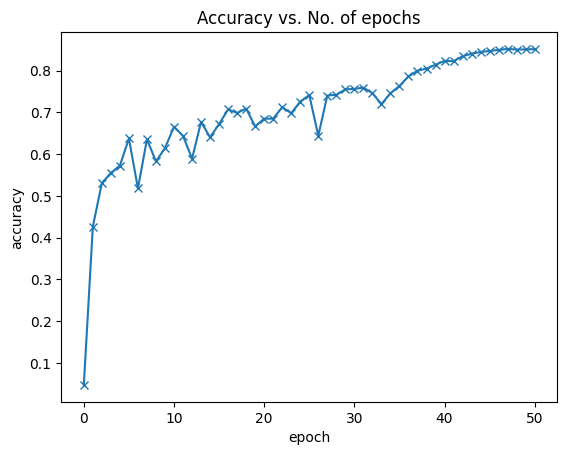

In [26]:
plot_accuracies(history)

In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

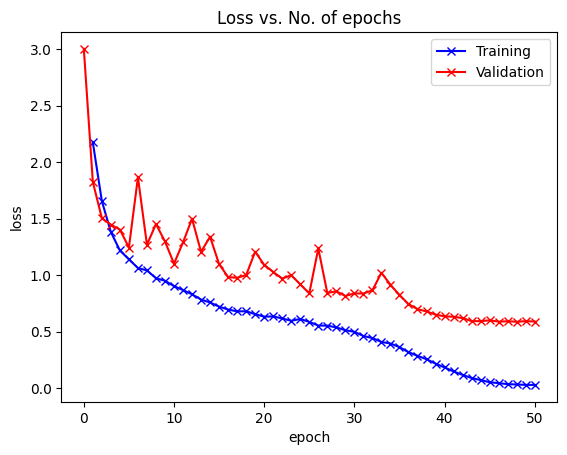

In [28]:
plot_losses(history)

In [29]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

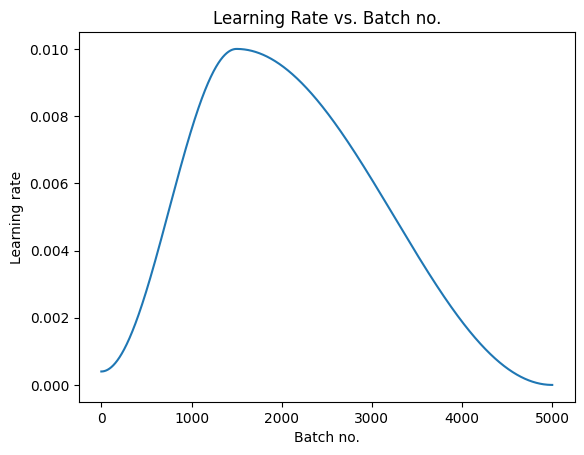

In [30]:
plot_lrs(history)

In [31]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')

In [34]:
ans=[]
model.eval()

from tqdm import tqdm

for inputs in tqdm(test_loader):
    inputs= inputs.to(device)
    outputs = model(inputs)
    # loss = criterion(outputs, labels)
    _, predicted = torch.max(outputs, 1)
    # running_loss += loss.item()
    # total += labels.size(0)
    # print(predicted)
    # correct += (predicted == labels).sum().item()
    ans.append(predicted.item())

    # print(predicted)

def writeSubmissionFile(labels, fn):
    f = open(fn, 'w')
    f.write("id,category\n")
    for ii, ll in enumerate(labels):
        f.write(str(ii) + "," + str(int(ll)) + "\n")

    f.close()


writeSubmissionFile(ans,'submit.csv')

100%|██████████| 10000/10000 [00:31<00:00, 316.50it/s]
